In [26]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
def plot_format(title,xlabel,ylabel):
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=10, rotation=0)
    plt.yticks(fontsize=10)    

# LOAD DATA

## Origination Data

In [28]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_orig_"


column_names=['fico', 'dt_first_pi', 'flag_fthb', 'dt_matr', 'cd_msa', 
              'mi_pct', 'cnt_units','occpy_sts', 'cltv', 'dti', 
              'orig_upb', 'ltv', 'int_rt', 'channel', 'ppmt_pnlty',
              'prod_type', 'st', 'prop_type', 'zipcode', 'id_loan', 
              'loan_purpose','orig_loan_term', 'cnt_borr', 'seller_name', 'servicer_name', 
              'flag_sc','program_ind']

def quarter(time):
    if time == "01" or time == "02" or time == "03": 
        return 'Q1'
    elif time == "04" or time == "05" or time == "06": 
        return 'Q2'
    elif time == "07" or time == "08" or time == "09": 
        return 'Q3'
    else:
        return 'Q4'

def read_file(y):
    file = pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False) # Some columns have mixed types -> use low_memory = False
    file['year'] = file['dt_first_pi'].astype(str).str[:4]
    file['month'] = file['dt_first_pi'].astype(str).str[-2:]
    file['quarter'] = file['year'] + file['month'].apply(quarter)
    return file[file['year'].astype(int) <= 2009]

ori_2008 = read_file(2008)
ori_2009 = read_file(2009)

ori = pd.concat([ori_2008, ori_2009])

ori.to_csv("origination_2008_2009.csv",index=False)
print(ori.shape)

(91579, 30)


## Performance Data

In [29]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_svcg_"

column_names=['id_loan','Period','Act_endg_upb','delq_sts','loan_age',
              'mths_remng','repch_flag','flag_mod','CD_Zero_BAL','Dt_zero_BAL',
              'New_Int_rt','Amt_Non_Int_Brng_Upb','Dt_Lst_Pi','MI_Recoveries','Net_Sale_Proceed',
              'Non_MI_Recoveries','Expenses','legal_costs','maint_pres_costs','taxes_ins_costs',
              'misc_costs','actual_loss','modcost','stepmod_ind','dpm_ind', 
              'eltv','zb_removal_upb','dlq_acrd_int','disaster_hardship_ind','borrower_assist_flag']

chuck_size = 1000 # Help loading big data -> MapReduce

def read_file(y):
    mylist = []
    for chunk in pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False, chunksize = chuck_size): # run functions in different chunks (for loop)
        chunk = chunk[chunk['Period'] <= (y+5)*100] # Selet only 5-year performance for each loan
        mylist.append(chunk)
    per = pd.concat(mylist, axis = 0)
    return per

per_2008 = read_file(2008)
per_2009 = read_file(2009)

performance = pd.concat([per_2008, per_2009])

performance.to_csv("performance_2008_2009.csv",index=False)
print(performance.shape)

(3713474, 30)


# PROJECT 1 – CHANGES IN MORTGAGE PORTFOLIO 

## Origination Data

In [116]:
ori = pd.read_csv("origination_2008_2009.csv",low_memory = False)

In [117]:
print(ori.shape)
print(ori.info())
ori.head(3)

(91579, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91579 entries, 0 to 91578
Data columns (total 30 columns):
fico              91579 non-null int64
dt_first_pi       91579 non-null int64
flag_fthb         91579 non-null object
dt_matr           91579 non-null int64
cd_msa            77364 non-null float64
mi_pct            91579 non-null int64
cnt_units         91579 non-null int64
occpy_sts         91579 non-null object
cltv              91579 non-null int64
dti               91579 non-null int64
orig_upb          91579 non-null int64
ltv               91579 non-null int64
int_rt            91579 non-null float64
channel           91579 non-null object
ppmt_pnlty        90354 non-null object
prod_type         91579 non-null object
st                91579 non-null object
prop_type         91579 non-null object
zipcode           91579 non-null int64
id_loan           91579 non-null object
loan_purpose      91579 non-null object
orig_loan_term    91579 non-null int64
cnt_borr

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,program_ind,year,month,quarter
0,735,200803,N,203802,44180.0,0,1,P,87,33,...,N,360,2,Other sellers,Other servicers,NaN,9,2008,3,2008Q1
1,733,200803,N,203802,44180.0,0,1,P,70,29,...,C,360,2,Other sellers,Other servicers,NaN,9,2008,3,2008Q1
2,682,200803,Y,203802,NaN,30,1,P,93,49,...,P,360,1,Other sellers,Other servicers,NaN,9,2008,3,2008Q1


In [118]:
# Define FICO band --> format: '###-###'
# FICO < 600 is considered subprime, FICO >= 800 is considered excellent
# https://www.investopedia.com/terms/f/ficoscore.asp

def fico_band(fico):
    if fico < 600: 
        return '500-599'
    elif fico < 670:
        return '600-669'
    elif fico < 740:
        return '670-739'
    elif fico < 800:
        return '740-799'
    else:
        return '800+'

# Create the 'fico_band'
ori['fico_band']=ori['fico'].apply(fico_band)

# Calculate the average for each fico band
ori['fico'].groupby(ori['fico_band']).mean()

fico_band
500-599    577.332542
600-669    646.458577
670-739    709.580829
740-799    773.130502
800+       828.183641
Name: fico, dtype: float64

### Hypotheses 1
- After the financial meltdown, loans in general have high credit scores (FICO)

fico_band   500-599    600-669    670-739    740-799       800+
quarter                                                        
2008Q1     1.828273  13.026445  34.280118  43.747960   7.117205
2008Q2     1.018699  11.073123  32.403014  45.974044   9.531119
2008Q3     0.608243  10.044018  32.757103  46.378551  10.212085
2008Q4     0.587434   9.066916  31.789545  47.846075  10.710029
2009Q1     0.465280   5.495567  27.539285  54.121675  12.378193
2009Q2     0.074372   2.461699  21.255392  59.720363  16.488175
2009Q3     0.021555   2.414140  21.382383  58.887771  17.294151
2009Q4     0.071505   3.360744  24.991062  57.087951  14.488738


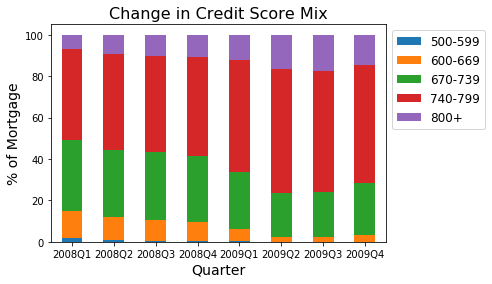

In [119]:
# Examine changes in credit score

# Table
credit_score = ori.groupby(['quarter', 'fico_band'])['fico'].size().groupby(level=0).apply(lambda x: x/x.sum()*100).unstack()
# use size() instead of count() because it includes the NaN
# groupby(level=0) -> same as groupby('quarter')
# apply(lambda x: x/x.sum()*100) -> get the percentage for each quarter
# unstack() -> unpivot the level of columns

print(credit_score)

# Plot
credit_score.plot(kind='bar',stacked=True)
    
plot_format('Change in Credit Score Mix','Quarter','% of Mortgage')
plt.legend(bbox_to_anchor=(1,1),fontsize=12)
plt.show()

### Hypotheses 2
- After the financial meltdown, the portion of subprime loans (FICO < 600) decreased substantially in the mortgage portfolio.


quarter
2008Q1    0.018283
2008Q2    0.010187
2008Q3    0.006082
2008Q4    0.005874
2009Q1    0.004653
2009Q2    0.000744
2009Q3    0.000216
2009Q4    0.000715
Name: subprime, dtype: float64


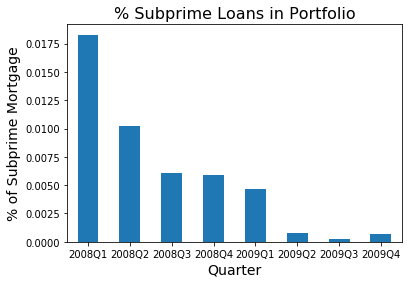

In [143]:
# Examine change in % of subprime mortgages in portfolio
ori['subprime']=np.where(ori['fico'] < 600, 1, 0)

##### % subprime by quarter #####
subprime = ori['subprime'].groupby(ori['quarter']).mean()
print(subprime)

subprime.plot(kind = 'bar')
plot_format('% Subprime Loans in Portfolio','Quarter','% of Subprime Mortgage')
plt.show()

### Hypotheses 3
- After the meltdown, the portion of purchases went down.

loan_purpose          C          N          P
quarter                                      
2008Q1        36.761345  33.496572  29.742083
2008Q2        38.598939  35.389339  26.011722
2008Q3        30.044018  19.703882  50.252101
2008Q4        28.579942  19.044781  52.375277
2009Q1        27.714863  40.093056  32.192081
2009Q2        30.715454  56.455451  12.829094
2009Q3        32.131053  45.157350  22.711596
2009Q4        31.757240  31.203075  37.039685


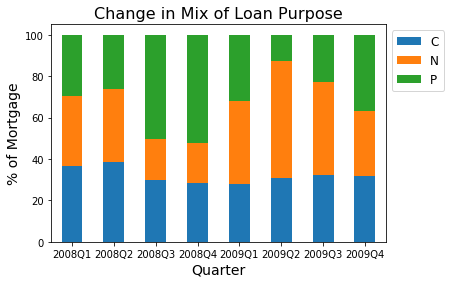

In [142]:
# Examine changes in loan purpose
loan_purpose = ori.groupby(['quarter', 'loan_purpose'])['fico'].size().groupby(level=0).apply(lambda x:100*x/x.sum()).unstack()

# P -> Purchase
# C -> Refinance – Cash Out
# N -> Refinance – No Cash Out

print(loan_purpose)

loan_purpose.plot(kind='bar',stacked=True)
plot_format('Change in Mix of Loan Purpose','Quarter','% of Mortgage')
plt.legend(bbox_to_anchor=(1,1),fontsize=12)

plt.show()

loan_purpose         C         N         P
quarter                                   
2008Q1        0.027531  0.014620  0.010977
2008Q2        0.016631  0.005915  0.006438
2008Q3        0.009856  0.007311  0.003344
2008Q4        0.009830  0.007152  0.003251
2009Q1        0.010453  0.002190  0.002727
2009Q2        0.000726  0.000263  0.002899
2009Q3        0.000447  0.000159  0.000000
2009Q4        0.001126  0.001146  0.000000


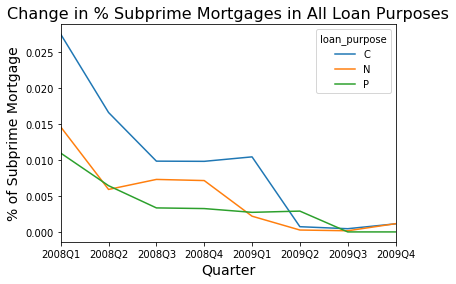

In [144]:
# Examine change in % of subprime mortgages by loan purpose

subprime_loan_purpose = pd.pivot_table(ori, values='subprime', index=['quarter'], columns=['loan_purpose'], aggfunc=np.mean, margins=False)
# same as ori.groupby(['quarter', 'loan_purpose'])['subprime'].mean().unstack()

print(subprime_loan_purpose)
subprime_loan_purpose.plot(kind = 'line')

plot_format('Change in % Subprime Mortgages in All Loan Purposes','Quarter','% of Subprime Mortgage')
plt.show()

## Performance Data (Definition of Delinquency)

In [167]:
per = pd.read_csv("performance_2008_2009.csv",low_memory = False)

In [263]:
# Add quarter and int_rt from ori
per_deli = pd.merge(ori[['id_loan', 'int_rt','quarter']], per, how = 'inner', on = 'id_loan') 
print(per_deli.shape)
per_deli.head(3)

(3407832, 32)


,id_loan,int_rt,quarter,Period,Act_endg_upb,delq_sts,loan_age,mths_remng,repch_flag,flag_mod,...,misc_costs,actual_loss,modcost,stepmod_ind,dpm_ind,eltv,zb_removal_upb,dlq_acrd_int,disaster_hardship_ind,borrower_assist_flag
0,F108Q1000024,6.25,2008Q1,200802,192000.0,0,0,360,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F108Q1000024,6.25,2008Q1,200803,192000.0,0,1,359,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F108Q1000024,6.25,2008Q1,200804,191000.0,0,2,358,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Definition 1 & 2 :
- A loan has reached 90+ days in delinquency
- Balance becomes zero, with delinquency flags 90+ days

In [264]:
### delq_sts -> Current Loan Delinquency Status
# 0 = Current, or less than 3- days past due
# 1 = 30-59 days delinquent
# 2 = 60-89 days delinquent
# 3 = 90-119 days delinquent
# And so on…
# R = REO Acquisition

per_deli['delq_sts_num']=pd.to_numeric(per_deli['delq_sts'], errors='coerce') 
# delq_sts has both str ("R") and int -> Error: '>=' not supported between instances of 'str' and 'int'
# errors = 'coerce' -> invalid parsing will be set as NaN -> remove the string "R"

### CD_Zero_BAL -> Zero Balance Code
# 01 = Prepaid or Matured (Voluntary Payoff)
# 02 = Third Party Sale
# 03 = Short Sale / Charge Off
# 06 = Repurchase prior to Property Disposition
# 09 = REO Disposition -> It is the same as when delq_sts == 'R'
# 15 = Note sale / Reperforming sale

per_deli.loc[(per_deli['delq_sts_num'] >= 3) | 
        (per_deli['CD_Zero_BAL'].isin(['3.0','6.0','9.0'])),'bad'] = 1
# Create a column called 'bad' --> True = 1, False = NaN

### Definition 3:
- 	A loan has shown recovery amount as recovery usually comes after foreclosure and repossession by the bank (REO)

In [265]:
# Recovery is usually associated with foreclosure and repossession.  
# Therefore, if a loan shows recovery, it must have gone bad before. 

# MI -> Mortgage Insurance
# Amt_Non_Int_Brng_Upb -> Current deferred unpaid principal balance (UPB)

max_recovery = per_deli.groupby(['id_loan'])['Non_MI_Recoveries', 'MI_Recoveries', 'Amt_Non_Int_Brng_Upb'].max().reset_index()
per_deli = pd.merge(per_deli, max_recovery, on='id_loan') # default: how = "inner"

per_deli.loc[(per_deli['delq_sts']=='R')| # REO
             (per_deli['Non_MI_Recoveries_y'] > 0) | (per_deli['MI_Recoveries_y'] > 0 ) | 
             (per_deli['Amt_Non_Int_Brng_Upb_y'] > 0), 'bad']=1
# Will replace the previous 'bad' column

### Definition 4:
- A loan has been modified, i.e., interest rate reduction after negotiating with the bank.

In [266]:
# If the loan has experienced a decrease in interest rate, the loan has been modified.
# A modified loan suggests the borrower has encountered financial hardship.

# flag_mod -> Modification Flag
per_deli.loc[(per_deli['flag_mod']=='Y'), 'bad']=1

# per -> New_Int_rt (Current interest rate); int_rt (Original interest rate)
min_new_int_rt = per_deli.groupby('id_loan')[['New_Int_rt']].min().reset_index()
per_deli = pd.merge(per_deli, min_new_int_rt, on='id_loan')

per_deli.loc[per_deli['New_Int_rt_y'] < per_deli['int_rt'], 'bad'] = 1

quarter
2008Q1    0.091530
2008Q2    0.069314
2008Q3    0.071388
2008Q4    0.063545
2009Q1    0.026894
2009Q2    0.006621
2009Q3    0.005480
2009Q4    0.005763
Name: deli, dtype: float64


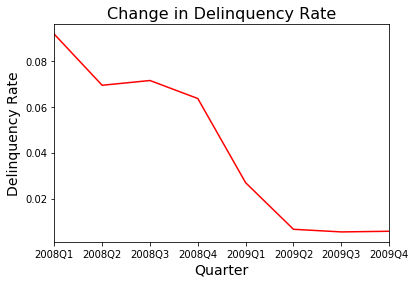

In [267]:
per_deli['deli']=np.where((per_deli['bad'] > 0), 1, 0)

delinquency_rate = per_deli['deli'].groupby(per_deli['quarter']).mean()

print(delinquency_rate)
delinquency_rate.plot(kind='line', color='red')

plot_format('Change in Delinquency Rate','Quarter','Delinquency Rate')
plt.show()

In [268]:
per_deli2 = per_deli.drop(['Non_MI_Recoveries_y','MI_Recoveries_y','Amt_Non_Int_Brng_Upb_y','New_Int_rt_y','bad'], axis=1)
per_deli2 = per_deli2.rename(columns={'Non_MI_Recoveries_x':'Non_MI_Recoveries','MI_Recoveries_x':'MI_Recoveries','Amt_Non_Int_Brng_Upb_x':'Amt_Non_Int_Brng_Upb','New_Int_rt_x':'New_Int_rt'})
ori_per_deli = pd.merge(ori, per_deli2.drop(['quarter','int_rt'],axis=1), how = "inner", on = "id_loan")
ori_per_deli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3407832 entries, 0 to 3407831
Data columns (total 63 columns):
fico                     int64
dt_first_pi              int64
flag_fthb                object
dt_matr                  int64
cd_msa                   float64
mi_pct                   int64
cnt_units                int64
occpy_sts                object
cltv                     int64
dti                      int64
orig_upb                 int64
ltv                      int64
int_rt                   float64
channel                  object
ppmt_pnlty               object
prod_type                object
st                       object
prop_type                object
zipcode                  int64
id_loan                  object
loan_purpose             object
orig_loan_term           int64
cnt_borr                 int64
seller_name              object
servicer_name            object
flag_sc                  object
program_ind              int64
year                     int64
mon

In [269]:
print(ori_per_deli.shape)
print(ori_per_deli['deli'].sum())
print(ori_per_deli['deli'].mean())

(3407832, 63)
123762
0.036316931116322636
